<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 100 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida
    3. Balanceo de los datos

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [2]:
df= pd.read_csv('features.csv')

In [3]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
17345,55.0,61.0,59.20,1.00,-0.58,-0.57,-0.57,-0.76,-0.74,-0.75,-0.33,-0.31,-0.32,1.0,1.0,21.0
25571,56.0,59.0,58.40,0.99,-0.28,-0.26,-0.27,-0.45,-0.43,-0.44,-0.85,-0.84,-0.85,1.0,2.0,30.0
2769,51.0,54.0,52.29,1.00,0.41,0.42,0.42,-0.36,-0.35,-0.36,-0.84,-0.84,-0.84,1.0,2.0,3.0
1410,77.0,83.0,80.20,1.00,-0.53,-0.52,-0.53,0.17,0.19,0.18,-0.84,-0.83,-0.83,0.0,5.0,1.0
5174,47.0,49.0,48.00,1.00,-0.14,-0.11,-0.13,-0.25,-0.22,-0.23,-0.97,-0.95,-0.96,1.0,2.0,5.0
15780,49.0,50.0,49.67,1.00,-0.45,-0.44,-0.44,0.20,0.21,0.20,-0.88,-0.87,-0.87,1.0,2.0,20.0
6368,54.0,56.0,55.33,0.99,-0.32,-0.32,-0.32,-0.93,-0.91,-0.93,0.14,0.14,0.14,1.0,2.0,6.0
22858,64.0,70.0,67.17,1.00,-0.07,-0.06,-0.06,-0.63,-0.63,-0.63,0.77,0.78,0.77,0.0,0.0,27.0
3477,48.0,50.0,49.00,1.00,-0.55,-0.55,-0.55,0.59,0.59,0.59,-0.59,-0.59,-0.59,0.0,5.0,3.0
7730,52.0,54.0,53.50,1.00,-0.05,-0.04,-0.04,-0.47,-0.46,-0.46,-0.89,-0.88,-0.89,1.0,2.0,8.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [4]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [23, 6, 10, 22, 18, 25, 26, 1, 17, 5, 11, 8, 29, 14, 20, 3, 27, 12, 19, 24, 4, 30, 21, 0]
7 sujetos de test: [2, 7, 9, 13, 15, 16, 28]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [5]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **100 ventanas** deslizantes y no con todas.

In [7]:
lista_ventanas=list(np.linspace(0,0.99,100))

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

In [8]:
labels=Train['Etiquetas multiclase']

lab_0 = []
idx_0 = []
list_idx_0 = []

for l in labels:
    if l==0:
        idx_0.append(True)
    else:
        idx_0.append(False)
list_idx_0.append(Train[idx_0])

lab_1 = []
idx_1 = []
list_idx_1 = []

for l in labels:
    if l==1:
        idx_1.append(True)
    else:
        idx_1.append(False)
list_idx_1.append(Train[idx_1])

lab_2 = []
idx_2 = []
list_idx_2 = []

for l in labels:
    if l==2:
        idx_2.append(True)
    else:
        idx_2.append(False)
list_idx_2.append(Train[idx_2])

lab_3 = []
idx_3 = []
list_idx_3 = []

for l in labels:
    if l==3:
        idx_3.append(True)
    else:
        idx_3.append(False)
list_idx_3.append(Train[idx_3])

lab_5 = []
idx_5 = []
list_idx_5 = []

for l in labels:
    if l==5:
        idx_5.append(True)
    else:
        idx_5.append(False)
list_idx_5.append(Train[idx_5])

Train0 = pd.DataFrame()  
for i in range(len(list_idx_0)):
    Train0=Train0.append(list_idx_0[i])
Train1 = pd.DataFrame()  
for i in range(len(list_idx_1)):
    Train1=Train1.append(list_idx_1[i])
Train2 = pd.DataFrame()  
for i in range(len(list_idx_2)):
    Train2=Train2.append(list_idx_2[i])
Train3 = pd.DataFrame()  
for i in range(len(list_idx_3)):
    Train3=Train3.append(list_idx_3[i])
Train5 = pd.DataFrame()  
for i in range(len(list_idx_5)):
    Train5=Train5.append(list_idx_5[i])

In [9]:
labels=Test['Etiquetas multiclase']

lab_0 = []
idx_0 = []
list_idx_0 = []

for l in labels:
    if l==0:
        idx_0.append(True)
    else:
        idx_0.append(False)
list_idx_0.append(Test[idx_0])

lab_1 = []
idx_1 = []
list_idx_1 = []

for l in labels:
    if l==1:
        idx_1.append(True)
    else:
        idx_1.append(False)
list_idx_1.append(Test[idx_1])

lab_2 = []
idx_2 = []
list_idx_2 = []

for l in labels:
    if l==2:
        idx_2.append(True)
    else:
        idx_2.append(False)
list_idx_2.append(Test[idx_2])

lab_3 = []
idx_3 = []
list_idx_3 = []

for l in labels:
    if l==3:
        idx_3.append(True)
    else:
        idx_3.append(False)
list_idx_3.append(Test[idx_3])

lab_5 = []
idx_5 = []
list_idx_5 = []

for l in labels:
    if l==5:
        idx_5.append(True)
    else:
        idx_5.append(False)
list_idx_5.append(Test[idx_5])

Test0 = pd.DataFrame()  
for i in range(len(list_idx_0)):
    Test0=Test0.append(list_idx_0[i])
Test1 = pd.DataFrame()  
for i in range(len(list_idx_1)):
    Test1=Test1.append(list_idx_1[i])
Test2 = pd.DataFrame()  
for i in range(len(list_idx_2)):
    Test2=Test2.append(list_idx_2[i])
Test3 = pd.DataFrame()  
for i in range(len(list_idx_3)):
    Test3=Test3.append(list_idx_3[i])
Test5 = pd.DataFrame()  
for i in range(len(list_idx_5)):
    Test5=Test5.append(list_idx_5[i])

In [10]:
n_lab=min([Train0['Etiquetas multiclase'].value_counts()[0],Train1['Etiquetas multiclase'].value_counts()[1],
      Train2['Etiquetas multiclase'].value_counts()[2],Train3['Etiquetas multiclase'].value_counts()[3],
      Train5['Etiquetas multiclase'].value_counts()[5]])
n_lab

149

In [11]:
Train_balanced = pd.DataFrame()  
Train_balanced=Train_balanced.append(Train0.sample(n_lab)).append(Train1.sample(n_lab)).append(Train2.sample(n_lab)).append(Train3.sample(n_lab)).append(Train5.sample(n_lab))

### 2.Normalización de los datos

In [12]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [13]:
Etiquetas = Train[['Etiquetas binarias','Etiquetas multiclase','ID']]

In [14]:
X_train=Train_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas multiclase'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas multiclase'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas multiclase'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas multiclase'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [15]:
Train.to_csv('Train.csv', header=True, index=False)
Train_balanced.to_csv('Train_balanced.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

### 3. Balanceo de los datos

SUBCONJUNTO DE TRAIN BALANCEADO

In [16]:
print('Número de valores diferentes que hay para etiquetas multiclase:',Train_balanced['Etiquetas multiclase'].nunique(),'\n')

print('Número de veces que se toma cada valor de etiquetas multiclase:')
print(Train_balanced['Etiquetas multiclase'].value_counts(),'\n')

Número de valores diferentes que hay para etiquetas multiclase: 5 

Número de veces que se toma cada valor de etiquetas multiclase:
5.0    149
3.0    149
2.0    149
1.0    149
0.0    149
Name: Etiquetas multiclase, dtype: int64 



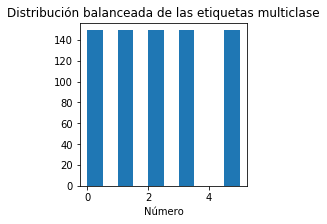

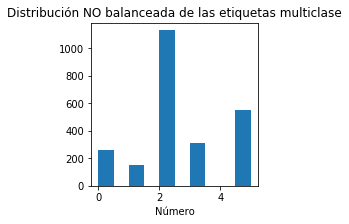

In [17]:
plt.figure(figsize=(3, 3))
plt.title('Distribución balanceada de las etiquetas multiclase')
plt.xlabel("Etiqueta del sueño")
plt.xlabel("Número")
plt.hist(Train_balanced['Etiquetas multiclase'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución NO balanceada de las etiquetas multiclase')
plt.xlabel("Etiqueta del sueño")
plt.xlabel("Número")
plt.hist(Train['Etiquetas multiclase'])
plt.show()

1.0    1590
0.0     810
Name: Etiquetas binarias, dtype: int64
1.0    536
0.0    164
Name: Etiquetas binarias, dtype: int64


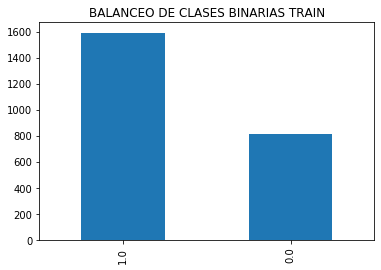

<Figure size 432x288 with 0 Axes>

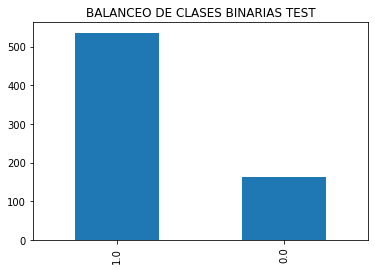

In [18]:
Train['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TRAIN")
plt.figure()
print(Train["Etiquetas binarias"].value_counts() )

#Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
plt.figure()
Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
print(Test["Etiquetas binarias"].value_counts() )

2.0    1130
5.0     551
3.0     311
0.0     259
1.0     149
Name: Etiquetas multiclase, dtype: int64
2.0    356
3.0    140
0.0     86
5.0     78
1.0     40
Name: Etiquetas multiclase, dtype: int64


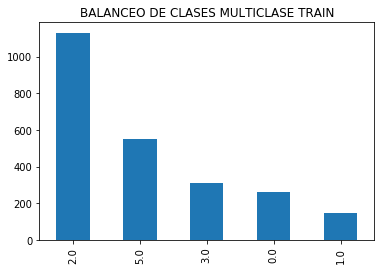

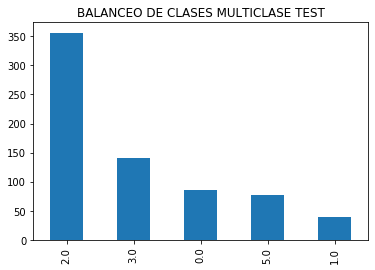

<Figure size 432x288 with 0 Axes>

In [19]:
Train['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TRAIN")
plt.figure()
print(Train["Etiquetas multiclase"].value_counts() )

Test['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TEST")
plt.figure()
print(Test["Etiquetas multiclase"].value_counts() )